In [33]:
# ============================================
# 0. IMPORT LIBRARIES
# ============================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier



In [34]:
# ============================
# 1. LOAD THE DATASET
# ============================

# Change the file name if needed
df = pd.read_csv("Dataset-Brief 1 Cyber.csv")

print("Shape:", df.shape)
df.head()


Shape: (21185, 84)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,175.45.176.3-149.171.126.19-60976-8022-6,175.45.176.3,60976,149.171.126.19,8022,6,22/01/2015 08:28:40 AM,234286,7,5,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Generic
1,175.45.176.2-149.171.126.18-5975-80-6,175.45.176.2,5975,149.171.126.18,80,6,18/02/2015 03:58:40 AM,5337881,63,371,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Exploits
2,175.45.176.2-149.171.126.15-4770-80-6,175.45.176.2,4770,149.171.126.15,80,6,18/02/2015 08:08:41 AM,557632,7,7,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Exploits
3,175.45.176.3-149.171.126.14-6151-80-6,175.45.176.3,6151,149.171.126.14,80,6,22/01/2015 07:59:44 AM,1287210,7,7,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
4,59.166.0.1-149.171.126.0-12897-5190-6,59.166.0.1,12897,149.171.126.0,5190,6,22/01/2015 03:19:03 PM,342,1,2,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [35]:
# ============================
# 2. DROP USELESS COLUMNS
# ============================

# These are identifiers, not useful patterns for ML
cols_to_drop = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']
df_clean = df.drop(columns=cols_to_drop)

print("Shape after dropping ID/IP/time columns:", df_clean.shape)


Shape after dropping ID/IP/time columns: (21185, 80)


In [36]:
# ============================================
# 3. REMOVE ZERO-ONLY COLUMNS
# ============================================

original_labels = df_clean['Label']
features = df_clean.drop(columns=['Label'])

zero_cols = features.columns[(features == 0).all()]
print("Zero columns:", list(zero_cols))

features = features.drop(columns=zero_cols)
print("Shape after removing zero columns:", features.shape)


Zero columns: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg']
Shape after removing zero columns: (21185, 70)


In [37]:
# ============================================
# 4. GROUP LABELS INTO 3 MAIN CLASSES
# ============================================

def group_label(lbl):
    if lbl == 'Benign':
        return 'Benign'
    elif lbl in ['Generic', 'Fuzzers', 'Reconnaissance']:
        return 'LowAttack'
    else:
        return 'HighAttack'

df_clean['MainLabel'] = original_labels.map(group_label)
df_clean['MainLabel'].value_counts()


,count
MainLabel,
HighAttack,9185
LowAttack,9000
Benign,3000


In [38]:
# ============================================
# 5. LABEL ENCODING
# ============================================

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_clean['MainLabel'])

print("Class mapping:")
for idx, name in enumerate(label_encoder.classes_):
    print(idx, "=", name)

X = features


Class mapping:
0 = Benign
1 = HighAttack
2 = LowAttack


In [39]:
# ============================================
# 6. TRAIN / TEST SPLIT
# ============================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((14829, 70), (6356, 70))

In [40]:
# ============================================
# 7. FEATURE SCALING
# ============================================

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [41]:
# ============================================
# 8. TRAIN SVM (RBF)
# ============================================

svm_model = SVC(
    kernel='rbf',
    C=5,
    gamma='scale',
    class_weight='balanced',
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)
print("✔ SVM model trained")


✔ SVM model trained


In [42]:
# ============================================
# 9. EVALUATE SVM MODEL
# ============================================

y_pred_svm = svm_model.predict(X_test_scaled)

y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels_svm = label_encoder.inverse_transform(y_pred_svm)

print("🔥 SVM Accuracy:", accuracy_score(y_test_labels, y_pred_labels_svm))
print(classification_report(y_test_labels, y_pred_labels_svm))
# Show confusion matrix
print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

🔥 SVM Accuracy: 0.8198552548772813
              precision    recall  f1-score   support

      Benign       0.96      0.98      0.97       900
  HighAttack       0.84      0.73      0.78      2756
   LowAttack       0.76      0.86      0.81      2700

    accuracy                           0.82      6356
   macro avg       0.86      0.86      0.85      6356
weighted avg       0.82      0.82      0.82      6356


📌 Confusion Matrix:
[[ 880   10   10]
 [  30 1999  727]
 [   3  365 2332]]


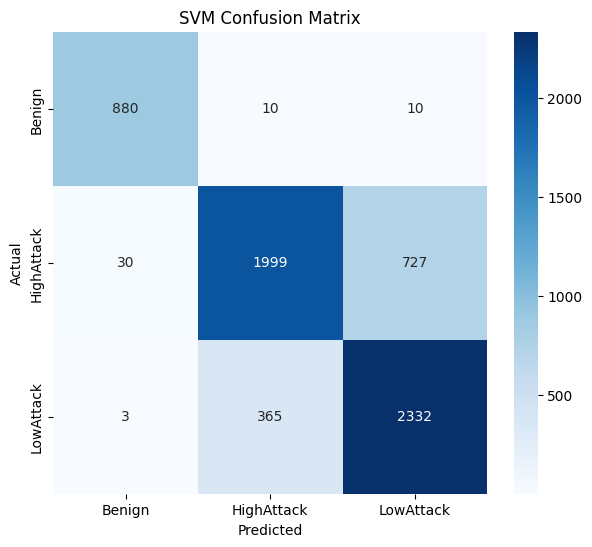

In [43]:
# ============================================
# 10. CONFUSION MATRIX (SVM)
# ============================================

class_names = list(label_encoder.classes_)

cm_svm = confusion_matrix(y_test_labels, y_pred_labels_svm, labels=class_names)

plt.figure(figsize=(7,6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


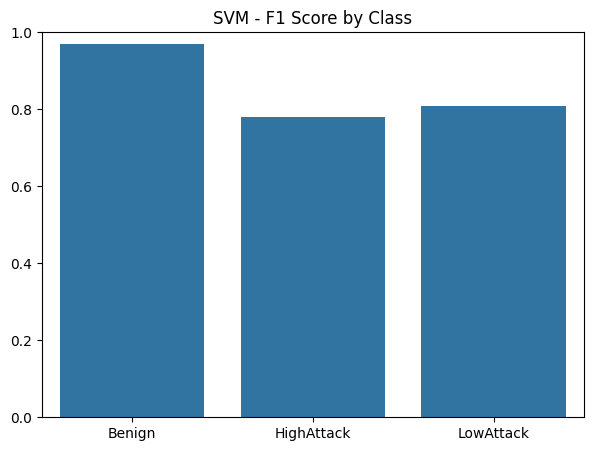

In [44]:
# ============================================
# 11. F1-SCORE BAR CHART (SVM)
# ============================================

report_svm = classification_report(
    y_test_labels, y_pred_labels_svm,
    labels=class_names,
    output_dict=True
)

f1_scores_svm = [report_svm[label]['f1-score'] for label in class_names]

plt.figure(figsize=(7,5))
sns.barplot(x=class_names, y=f1_scores_svm)
plt.ylim(0,1)
plt.title("SVM - F1 Score by Class")
plt.show()


In [45]:
# ============================================
# 12. TRAIN XGBOOST MODEL
# ============================================

xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    learning_rate=0.1,
    max_depth=8,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train_scaled, y_train)
print("✔ XGBoost model trained")


✔ XGBoost model trained


In [46]:
# ============================================
# 13. EVALUATE XGBOOST MODEL
# ============================================

y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_labels_xgb = label_encoder.inverse_transform(y_pred_xgb)

print("🔥 XGBoost Accuracy:", accuracy_score(y_test_labels, y_pred_labels_xgb))
print(classification_report(y_test_labels, y_pred_labels_xgb))
# Show confusion matrix for XGBoost
print("\n📌 XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


🔥 XGBoost Accuracy: 0.921019509125236
              precision    recall  f1-score   support

      Benign       1.00      0.98      0.99       900
  HighAttack       0.91      0.91      0.91      2756
   LowAttack       0.91      0.91      0.91      2700

    accuracy                           0.92      6356
   macro avg       0.94      0.93      0.94      6356
weighted avg       0.92      0.92      0.92      6356


📌 XGBoost Confusion Matrix:
[[ 885    5   10]
 [   1 2518  237]
 [   0  249 2451]]


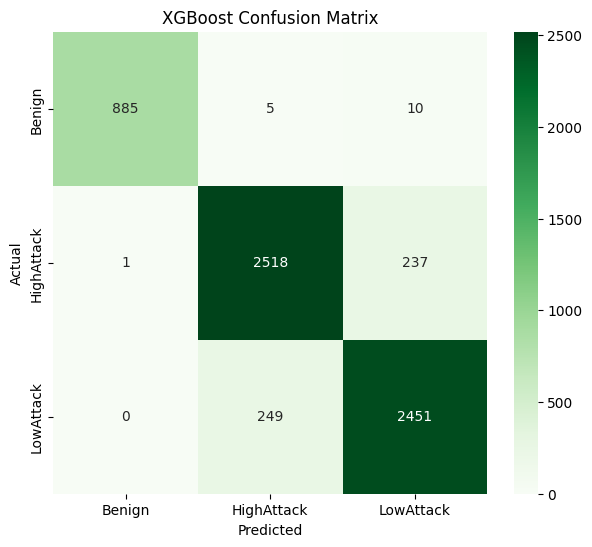

In [47]:
# ============================================
# 14. CONFUSION MATRIX (XGBOOST)
# ============================================

cm_xgb = confusion_matrix(y_test_labels, y_pred_labels_xgb, labels=class_names)

plt.figure(figsize=(7,6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)

plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/tmp/ipython-input-159402183.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=f1_scores_xgb, palette='viridis')


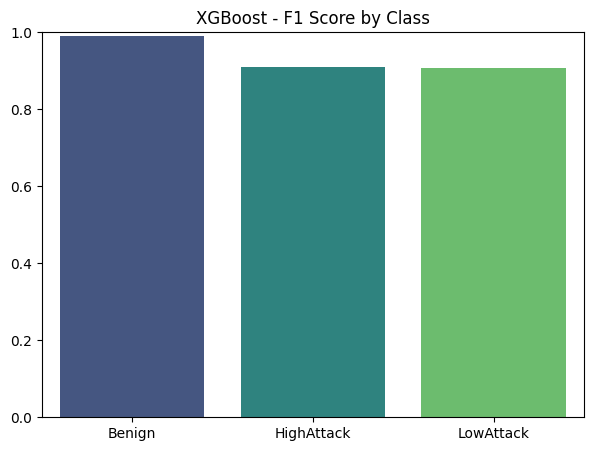

In [48]:
# ============================================
# 15. F1-SCORE BAR CHART (XGBOOST)
# ============================================

report_xgb = classification_report(
    y_test_labels,
    y_pred_labels_xgb,
    labels=class_names,
    output_dict=True
)

f1_scores_xgb = [report_xgb[label]['f1-score'] for label in class_names]

plt.figure(figsize=(7,5))
sns.barplot(x=class_names, y=f1_scores_xgb, palette='viridis')
plt.ylim(0,1)
plt.title("XGBoost - F1 Score by Class")
plt.show()
